In [1]:
import pandas as pd # library for data analsysis
import json # library to handle JSON files
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import matplotlib.pyplot as plt # Matplotlib for plotting
import folium # map rendering library
from folium.features import DivIcon # markers on maps
import seaborn as sb # additional plotting library Seaborn
# Shapely library to check if a venue is inside the city
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

print('Libraries imported.')

Libraries imported.


In [31]:
# constants
geodata_path = "./data/frankfurt.geojson" # path to geojson file
frankfurt_lat = 50.11552 # latitude of Frankfurt
frankfurt_lng = 8.7 # longitude of Frankfurt

# Population Data

First, we get data about the population of Frankfurt. The German Wikipedia page contains a preformatted table which can be easily read with pandas. The original can be found here: https://www.frankfurt.de/sixcms/media.php/738/01_Bev%C3%B6lkerung_Ende2018.pdf

In [60]:
# read wikipedia table into dataframe
df = pd.read_html('https://de.wikipedia.org/wiki/Liste_der_Stadtteile_von_Frankfurt_am_Main',
                  decimal=',',
                  thousands='.',
                  flavor='bs4')[0]
print(df.shape)
df

(47, 13)


Nr.                Stadtteil  Fläche[3]in km²  \
0            1                 Altstadt            0.506   
1            2               Innenstadt            1.491   
2            3          Bahnhofsviertel            0.542   
3            4              Westend-Süd            2.497   
4            5             Westend-Nord            1.632   
5            6             Nordend-West            3.100   
6            7              Nordend-Ost            1.532   
7            8                   Ostend            5.564   
8            9                 Bornheim            2.786   
9           10           Gutleutviertel            1.792   
10          11                   Gallus            4.517   
11          12               Bockenheim            8.031   
12          13       Sachsenhausen-Nord            4.235   
13          14        Sachsenhausen-Süd           30.535   
14          15                Flughafen           24.176   
15          16                  Oberrad            2.708   
16          17                Niederrad            6.124   
17          18               Schwanheim           14.773   
18          19                Griesheim            5.100   
19          20                Rödelheim            4.660   
20          21                   Hausen            1.246   
21  22[Anm. 9]                Praunheim            5.153   
22          24              Heddernheim            2.514   
23          25              Niederursel            7.422   
24          26                 Ginnheim            2.695   
25          27                Dornbusch            2.384   
26          28              Eschersheim            3.232   
27          29                Eckenheim            2.254   
28          30             Preungesheim            3.680   
29          31                  Bonames            1.372   
30          32              Berkersheim            3.185   
31          33               Riederwald            1.074   
32          34                 Seckbach            7.999   
33          35               Fechenheim            6.984   
34          36                   Höchst            4.597   
35          37                     Nied            3.708   
36          38               Sindlingen            3.968   
37          39                Zeilsheim            5.467   
38          40          Unterliederbach            6.021   
39          41               Sossenheim            5.919   
40          42         Nieder-Erlenbach            8.367   
41          43         Kalbach-Riedberg            6.580   
42          44                  Harheim            4.837   
43          45          Nieder-Eschbach            6.348   
44          46           Bergen-Enkheim           12.601   
45          47         Frankfurter Berg            2.400   
46         NaN  Stadt Frankfurt am Main          248.310   

                               Einwohner  \
0                                   4151   
1                                   6605   
2                                   3561   
3                                  18822   
4                                  10198   
5                                  30518   
6                                  23028   
7                                  29171   
8                                  30533   
9                                   6924   
10                                 40250   
11                                 40792   
12                                 32484   
13                                 28440   
14  Daten in Sachsenhausen-Süd enthalten   
15                                 13517   
16                                 25557   
17                                 20622   
18                                 24028   
19                                 18865   
20                                  7458   
21                                 16524   
22                                 17178   
23                                 16186   
24                            

There is one row for each district in Frankfurt and another one for the whole city. In addition, the *Flughafen* district does not contain its own data, but it is included in the row for *Sachsenhausen-Süd*. The DataFrame now has to be cleaned in the following ways:
1. Remove unimportant columns
2. Remove summary row
3. Rename columns to English names
4. Copy missing data from *Sachsenhausen-Süd* to *Flughafen*
5. Set data types to numeric data types

In [61]:
# Remove unimportant columns
df.drop(["Nr.", "Vorherige Zugehörigkeit", "Ortsbezirk", "Stadtteilseit"], axis=1, inplace=True)
# Remove sumary row
df.drop([46], inplace=True)

In [62]:
# Rename columns to English names
df.rename(columns={"Stadtteil": "District",
                   "Fläche[3]in km²": "Area in square km",
                   "Einwohner": "Inhabitants",
                   "Weiblich": "Female",
                   "Männlich": "Male",
                   "Deutsche": "Germans",
                   "Ausländer": "Foreigners",
                   "Ausländerin Prozent": "Foreigners in percent",
                   "Einwohnerje km²": "Inhabitants per square km",
                   "Ortsbezirk": "Area District"},
            inplace=True)

# increment index in order to have it be equal to the Number column in the original data
df.index += 1

In [63]:
# Copy missing data from Sachsenhausen-Süd to Flughafen
df.loc[15, "Inhabitants"] = df.loc[14, "Inhabitants"]
df.loc[15, "Female"] = df.loc[14, "Female"]
df.loc[15, "Male"] = df.loc[14, "Male"]
df.loc[15, "Germans"] = df.loc[14, "Germans"]
df.loc[15, "Foreigners"] = df.loc[14, "Foreigners"]
df.loc[15, "Foreigners in percent"] = df.loc[14, "Foreigners in percent"]
df.loc[15, "Inhabitants per square km"] = df.loc[14, "Inhabitants per square km"]

In [64]:
# Set data types to numeric data types
df = df.astype({"Inhabitants": "int32",
           "Female": "int32",
           "Male": "int32",
           "Germans": "int32",
           "Foreigners": "int32",
           "Foreigners in percent": "float32",
           "Inhabitants per square km": "int32"})

In [67]:
print(df.shape)
df.head()

(46, 9)


District  Area in square km  Inhabitants  Female  Male  Germans  \
1         Altstadt              0.506         4151    2015  2136     2604   
2       Innenstadt              1.491         6605    3088  3517     3514   
3  Bahnhofsviertel              0.542         3561    1378  2183     1638   
4      Westend-Süd              2.497        18822    9593  9229    13655   
5     Westend-Nord              1.632        10198    5321  4877     7214   

   Foreigners  Foreigners in percent  Inhabitants per square km  
1        1547              37.299999                       8204  
2        3091              46.799999                       4430  
3        1923              54.000000                       6570  
4        5167              27.500000                       7538  
5        2984              29.299999                       6249

# Geodata

The second part of the data is a GeoJSON file which contains the borders of each district. Theses borders can be used to assign each venue we find later to one of the districts. The original file can be found here: https://github.com/codeforamerica/click_that_hood/blob/master/public/data/frankfurt-main.geojson

In [68]:
with open(geodata_path) as json_file:
    geo_data = json.load(json_file)

So far we have no information about where each district center is located. In order to find rough estimates for each district center, the minimum *latitude/longitude* and maximum *latitude/longitude* is searched and the halfway point between those values is used.

In [69]:
# find a district by finding the halfway point between min/max lat/long
def find_district_center(coordinates):
    # each lat/long is roughly around 8.6/50.0 so initialization is appropriate
    min_lng = 99
    min_lat = 99
    max_lng = 0
    max_lat = 0
    
    # each point in shape is checked
    for lng, lat in coordinates:
        if lng > max_lng:
            max_lng = lng
        elif lng < min_lng:
            min_lng = lng
            
        if lat > max_lat:
            max_lat = lat
        elif lat < min_lat:
            min_lat = lat
    
    # calculate half way point between min and max
    center_lng = min_lng + ((max_lng - min_lng) / 2);
    center_lat = min_lat + ((max_lat - min_lat) / 2);
    
    return center_lng, center_lat

In [70]:
# interate over all district shapes in the GeoJSON file
for district in geo_data["features"]:
    # get name and shape of current district
    name = district["properties"]["name"]
    shape_of_district = district["geometry"]["coordinates"][0][0]
    
    #calculate district center
    lng, lat = find_district_center(shape_of_district)
    
    # add the calculated lat/long to the dataframe
    df.loc[df['District'] == name, "Lat"] = lat
    df.loc[df['District'] == name, "Lng"] = lng

In [71]:
print(df.shape)
df

(46, 11)


District  Area in square km  Inhabitants  Female   Male  \
1             Altstadt              0.506         4151    2015   2136   
2           Innenstadt              1.491         6605    3088   3517   
3      Bahnhofsviertel              0.542         3561    1378   2183   
4          Westend-Süd              2.497        18822    9593   9229   
5         Westend-Nord              1.632        10198    5321   4877   
6         Nordend-West              3.100        30518   15625  14893   
7          Nordend-Ost              1.532        23028   11947  11081   
8               Ostend              5.564        29171   14980  14191   
9             Bornheim              2.786        30533   16110  14423   
10      Gutleutviertel              1.792         6924    3027   3897   
11              Gallus              4.517        40250   18866  21384   
12          Bockenheim              8.031        40792   20482  20310   
13  Sachsenhausen-Nord              4.235        32484   16626  15858   
14   Sachsenhausen-Süd             30.535        28440   14682  13758   
15           Flughafen             24.176        28440   14682  13758   
16             Oberrad              2.708        13517    6725   6792   
17           Niederrad              6.124        25557   12809  12748   
18          Schwanheim             14.773        20622   10569  10053   
19           Griesheim              5.100        24028   11121  12907   
20           Rödelheim              4.660        18865    9478   9387   
21              Hausen              1.246         7458    3847   3611   
22           Praunheim              5.153        16524    8513   8011   
23         Heddernheim              2.514        17178    9036   8142   
24         Niederursel              7.422        16186    8360   7826   
25            Ginnheim              2.695        16647    8693   7954   
26           Dornbusch              2.384        18569    9840   8729   
27         Eschersheim              3.232        15225    7886   7339   
28           Eckenheim              2.254        14395    7424   6971   
29        Preungesheim              3.680        15567    7919   7648   
30             Bonames              1.372         6372    3266   3106   
31         Berkersheim              3.185         3817    1934   1883   
32          Riederwald              1.074         4991    2544   2447   
33            Seckbach              7.999        10748    5376   5372   
34          Fechenheim              6.984        17546    8344   9202   
35              Höchst              4.597        15730    7571   8159   
36                Nied              3.708        19780    9739  10041   
37          Sindlingen              3.968         9110    4461   4649   
38           Zeilsheim              5.467        12489    6188   6301   
39     Unterliederbach              6.021        17020    8463   8557   
40          Sossenheim              5.919        16247    8178   8069   
41    Nieder-Erlenbach              8.367         4721    2390   2331   
42    Kalbach-Riedberg              6.580        20756   10529  10227   
43             Harheim              4.837         4935    2515   2420   
44     Nieder-Eschbach              6.348        11453    5905   5548   
45      Bergen-Enkheim             12.601        18074    9300   8774   
46    Frankfurter Berg              2.400         8244    4154   4090   

    Germans  Foreigners  Foreigners in percent  Inhabitants per square km  \
1      2604        1547              37.299999                       8204   
2      3514        3091              46.799999                       4430   
3      1638        1923              54.000000                       6570   
4     13655        5167              27.500000                       7538   
5      7214        2984              29.299999                       6249   
6     23744        6774              22.200001                       9845   
7     17863        5165              22.400

Now, that we have estimates for the city center, let's show their locations on a map.

In [74]:
# create a folium map centered on Frankfurt
m = folium.Map(
    location=[frankfurt_lat, frankfurt_lng],
    zoom_start=11
)

# add a choropleth map showing the population of each district
folium.Choropleth(
    geo_data=geodata_path,
    name='choropleth',
    data=df,
    columns=['District', 'Inhabitants'],
    key_on='feature.properties.name',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=1,
    legend_name='Population'
).add_to(m)

# print the district number at the estimated city center
for index, row in df.iterrows():
    lng = row["Lng"]
    lat = row["Lat"]
    html = '<div style="font-size: 12pt; color: black;">' + str(index) + '</div>'
    
    folium.Marker([lat, lng], icon=DivIcon(
        icon_size=(150,36),
        icon_anchor=(7,20),
        html=html,
        )).add_to(m)
    
m

In [75]:
# save dataframe to storage
# df.to_csv("./data/census_data.csv", encoding='utf-8', index=False)

# Find venues with Foursquare

We now start using the Foursquare API to get venue information. We will use the `GET https://api.foursquare.com/v2/venues/search`endpoint of the API which returns a list of venues near a location. There are 5 cuisines we want to search for. Namely, German, Turkish, Italian, Greek and Chinese. We will query the API a total of 230 times, once for each `DISTRICT x CUISINE` combination.

In [76]:
CLIENT_ID = None # removed before publishing
CLIENT_SECRET = None # removed before publishing
VERSION = '20180605' # Foursquare API version

In [116]:
LIMIT = 500 # limit of number of venues returned by Foursquare API

radius = 3000 # define radius

# the values in the dict correspond to the category ID for the Foursquare API
cuisines = {"DE": "4bf58dd8d48988d10d941735",
            "TR": "4f04af1f2fb6e1c99f3db0bb",
            "IT": "4bf58dd8d48988d110941735",
            "GR": "4bf58dd8d48988d10e941735",
            "CN": "4bf58dd8d48988d145941735"}

In [79]:
results = {"DE" : [],
           "TR" : [],
           "IT" : [],
           "GR" : [],
           "CN" : []}

for cuisine_country, cuisine_api_id in cuisines.items():
    for index, row in df.iterrows():

        district_lng = row["Lng"]
        district_lat = row["Lat"]
        
        # one query for each district and cuisine combination with a max radius of 3000 meters
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION, 
                district_lat, 
                district_lng, 
                radius, 
                LIMIT,
                cuisine_api_id)
        
        #send API request
        #results[cuisine_country].append(requests.get(url).json())

In [215]:
num_venues = 0

for cuisine in cuisines.keys():
    for district in results[cuisine]:
        num_venues += len(district["response"]["venues"])
        
num_venues

5894

The API has returned 5894 results. As some districts are very close to each other, it is inevitable that duplicate entries exist. The next step is to clean the data and create a DataFrame.

In [236]:
def create_dataframe(cuisine):
    venues = None
    
    # iterate over districts and create a raw dataframe
    for i, district in enumerate(results[cuisine]):
        if venues is not None:
            venues = venues.append(json_normalize(district["response"]["venues"]))
        else:
            venues = json_normalize(district["response"]['venues'])
            
    # only keep relevant info
    venues = venues[['name', 'id', 'location.address', 'location.lat', 'location.lng']]
    # rename columns
    venues.columns = ['Name', 'ID','Address', 'Lat', 'Lng']
    # drop duplicate rows
    venues = venues.drop_duplicates()
    # add info about served cuisine
    venues["Cuisine"] = cuisine
    
    return venues

In [237]:
all_venues = None

for cuisine in cuisines.keys():
    if all_venues is not None:
        all_venues = all_venues.append(create_dataframe(cuisine))
    else:
        all_venues = create_dataframe(cuisine)
        
all_venues.reset_index(drop=True, inplace=True)

In [238]:
print(all_venues.shape)
print(all_venues.groupby("Cuisine").count()["Name"])
all_venues.head()

(1056, 6)
Cuisine
CN     86
DE    349
GR    100
IT    302
TR    219
Name: Name, dtype: int64


Name                        ID  \
0        Zum Standesämtchen  4c3b6d08def90f470beefd2d   
1  Wirtshaus am Hühnermarkt  5c180459a4b51b002c093a70   
2     Frankfurter Wirtshaus  5b3225a7e65d0c002c94296b   
3                Max on One  4e9dc4dff5b95ad93faa8788   
4  Heimat – Essen und Weine  4cfd2a882c1aa090410e057a   

                   Address        Lat       Lng Cuisine  
0             Römerberg 23  50.110296  8.682389      DE  
1              Markt 16-18  50.110777  8.684000      DE  
2               Mainkai 35  50.109050  8.681975      DE  
3  Thurn-und-Taxis-Platz 2  50.115110  8.680233      DE  
4         Berliner Str. 70  50.111125  8.678286      DE

The new `all_venues` dataframe now has 1056 unique entries. Each cuisine has the following count:

German: 349

Turkish: 219

Italian: 302

Greek: 100

Chinese: 86

Let us see where they are located on the map.

In [239]:
# create a folium map centered on Frankfurt
m = folium.Map(
    location=[frankfurt_lat, frankfurt_lng],
    zoom_start=11  # Limited levels of zoom for free Mapbox tiles.
)

# add district borders
folium.GeoJson(
    geodata_path,
    name='geojson'
).add_to(m)

# define individual colors for each cuisine
colors = {"DE": "red",
          "TR": "blue",
          "IT": "green",
          "GR": "purple",
          "CN": "orange"}

# place a marker on the map for each found venue
for index, row in all_venues.iterrows():
    lat = row["Lat"]
    lng = row["Lng"]
    label = row["Name"]
    color = colors[row["Cuisine"]]
    
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
                [lat, lng],
                radius=5,
                popup=label,
                color=color,
                fill=True,
                fill_color='#3186cc',
                fill_opacity=0.7,
                parse_html=False).add_to(m)

# add a legend to the map
legend_html =   '''
                <div style="position: fixed;
                            background: black;
                            opacity: 0.7;
                            color: white;
                            bottom: 350px; left: 200px; width: 100px; height: 150px; 
                            border:2px solid grey; z-index:9999; font-size:14px;
                            ">&nbsp; Cuisines <br><br>
                              &nbsp; <i class="fa fa-circle-o " style="color:red"></i> &nbsp; German<br>
                              &nbsp; <i class="fa fa-circle-o " style="color:blue"></i> &nbsp; Turkish<br>
                              &nbsp; <i class="fa fa-circle-o " style="color:green"></i> &nbsp; Italian<br>
                              &nbsp; <i class="fa fa-circle-o " style="color:purple"></i> &nbsp; Greek<br>
                              &nbsp; <i class="fa fa-circle-o " style="color:orange"></i> &nbsp; Chinese
                </div>
                ''' 
m.get_root().html.add_child(folium.Element(legend_html))

m

Due to the radius setting in the query, the results also contain venues which are outside of Frankfurt. We are now going to filter those out with the `shapely` library.

Each district in the GeoJSON file consists of multiple points. These points define a polygon. We now convert these polygons to a `shapely.Polygon`

In [240]:
polygons = []
district_polygons = {}

# convert each district to a shapely Polygon and save them in a dict:
# "district name": Polygon
for district in geo_data["features"]:
    district_name = district["properties"]["name"]
    
    shape_of_district = district["geometry"]["coordinates"][0][0]
    points = [(p[0], p[1]) for p in shape_of_district]
    district_polygon = Polygon(points)
    
    district_polygons[district_name] = district_polygon

In [253]:
# check whether a point is within a polygon
# i.e. echeck whether a venue(lng, lat) is inside a district(list(lng,lat))
# returns "None" if it is not within a district of Frankfurt
def is_within_borders(point, polygons):
    for name, polygon in district_polygons.items():
        if polygon.contains(point):
            return name
        
    return "None"

In [254]:
# Create a mask which shows which venues are within the borders of Frankfurt
keep_mask = []

for index, row in all_venues.iterrows():
    point = Point(row["Lng"], row["Lat"])
    keep_mask.append(is_within_borders(point, district_polygons))

In [256]:
# apply the mask to the "District" column
all_venues["District"] = keep_mask
# drop all rows which are tagged "None"
all_venues = all_venues[all_venues["District"] != "None"]

In [265]:
all_venues.shape

(825, 7)

The filtered DataFrame now contains only 825 venues. Let's see the effect of the filtering on the map.

In [261]:
# create a folium map centered on Frankfurt
m = folium.Map(
    location=[frankfurt_lat, frankfurt_lng],
    zoom_start=11  # Limited levels of zoom for free Mapbox tiles.
)

# add district borders
folium.GeoJson(
    geodata_path,
    name='geojson'
).add_to(m)

# define individual colors for each cuisine
colors = {"DE": "red",
          "TR": "blue",
          "IT": "green",
          "GR": "purple",
          "CN": "orange"}

# place a marker on the map for each found venue
for index, row in all_venues.iterrows():
    lat = row["Lat"]
    lng = row["Lng"]
    label = row["Name"]
    color = colors[row["Cuisine"]]
    
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
                [lat, lng],
                radius=5,
                popup=label,
                color=color,
                fill=True,
                fill_color='#3186cc',
                fill_opacity=0.7,
                parse_html=False).add_to(m)

# add a legend to the map
legend_html =   '''
                <div style="position: fixed;
                            background: black;
                            opacity: 0.7;
                            color: white;
                            bottom: 350px; left: 200px; width: 100px; height: 150px; 
                            border:2px solid grey; z-index:9999; font-size:14px;
                            ">&nbsp; Cuisines <br><br>
                              &nbsp; <i class="fa fa-circle-o " style="color:red"></i> &nbsp; German<br>
                              &nbsp; <i class="fa fa-circle-o " style="color:blue"></i> &nbsp; Turkish<br>
                              &nbsp; <i class="fa fa-circle-o " style="color:green"></i> &nbsp; Italian<br>
                              &nbsp; <i class="fa fa-circle-o " style="color:purple"></i> &nbsp; Greek<br>
                              &nbsp; <i class="fa fa-circle-o " style="color:orange"></i> &nbsp; Chinese
                </div>
                ''' 
m.get_root().html.add_child(folium.Element(legend_html))

m

Indeed, the `all_venues` DataFrame now only contains venues which are within the borders.

In [262]:
# save dataframe to storage
# all_venues.to_csv("./data/all_venues.csv", encoding="utf-8", index=False)

# Get venue details with Foursquare

Now, we want to use the Foursquare API to get details for all the venues we have found so far. We use the `GET https://api.foursquare.com/v2/venues/VENUE_ID` endpoint for that.

In [351]:
CLIENT_ID = None # Removed before publishing
CLIENT_SECRET = None # Removed before publishing
VERSION = '20180605' # Foursquare API version

In [363]:
all_venue_details = []

for venue_id in all_venues["ID"]:
    
    # construct a URL with each venue id
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(
                venue_id,
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION 
                )
    # send API request
    #all_venue_details.append(requests.get(url).json())

In [372]:
venue_details_df = None

# iterate over all the query results
for venue in all_venue_details:
    # a status code of 200 means the query was successful
    if venue["meta"]["code"] == 200:
        info = json_normalize(venue['response']['venue'])

        if venue_details_df is not None:
            venue_details_df = venue_details_df.append(info)
        else:
            venue_details_df = info

# only keep relevant columns
venue_details_df = venue_details_df[["id", "likes.count", "listed.count", "photos.count", "price.tier", "rating", "ratingSignals", "tips.count"]]
# rename columns
venue_details_df.columns = ['ID', 'Likes','Listed', 'Photos', 'Price', 'Rating', 'Rating Signals', 'Tips']
# reset index
venue_details_df = venue_details_df.reset_index(drop=True)

In [376]:
print(venue_details_df.shape)
venue_details_df.head()

(825, 8)


ID  Likes  Listed  Photos  Price  Rating  \
0  4c3b6d08def90f470beefd2d   25.0       5      86    2.0     6.1   
1  5c180459a4b51b002c093a70    2.0       1       4    2.0     NaN   
2  5b3225a7e65d0c002c94296b    7.0       1      10    2.0     5.5   
3  4e9dc4dff5b95ad93faa8788   16.0      15      44    2.0     8.6   
4  4cfd2a882c1aa090410e057a   43.0     136      49    2.0     8.7   

   Rating Signals  Tips  
0            60.0    19  
1             NaN     1  
2            21.0     6  
3            17.0     3  
4            59.0    16

The resulting DataFrame has one entry for each venue. With that we conclude the data collection.

In [358]:
# save DataFrame to storage
# venue_details_df.to_csv("./data/venue_details.csv", encoding="utf-8", index=False)

# Analysis of Cuisines

We now want to start analysing the data we have collected. We first reload the three dataframes and check that everything is correct.

In [3]:
df_census = pd.read_csv("./data/census_data.csv", encoding="utf-8")
df_venues = pd.read_csv("./data/all_venues.csv", encoding='utf-8')
df_details = pd.read_csv("./data/venue_details.csv", encoding="utf-8")
print("Data loaded.")

Data loaded.


In [7]:
print(df_census.shape)
df_census.head()

(46, 11)


District  Area in square km  Inhabitants  Female  Male  Germans  \
0         Altstadt              0.506         4151    2015  2136     2604   
1       Innenstadt              1.491         6605    3088  3517     3514   
2  Bahnhofsviertel              0.542         3561    1378  2183     1638   
3      Westend-Süd              2.497        18822    9593  9229    13655   
4     Westend-Nord              1.632        10198    5321  4877     7214   

   Foreigners  Foreigners in percent  Inhabitants per square km        Lat  \
0        1547                   37.3                       8204  50.110590   
1        3091                   46.8                       4430  50.112817   
2        1923                   54.0                       6570  50.107810   
3        5167                   27.5                       7538  50.117950   
4        2984                   29.3                       6249  50.129776   

        Lng  
0  8.681539  
1  8.682205  
2  8.667658  
3  8.661165  
4  8.666019

In [8]:
print(df_venues.shape)
df_venues.head()

(825, 7)


Name                        ID  \
0        Zum Standesämtchen  4c3b6d08def90f470beefd2d   
1  Wirtshaus am Hühnermarkt  5c180459a4b51b002c093a70   
2     Frankfurter Wirtshaus  5b3225a7e65d0c002c94296b   
3                Max on One  4e9dc4dff5b95ad93faa8788   
4  Heimat – Essen und Weine  4cfd2a882c1aa090410e057a   

                   Address        Lat       Lng Cuisine    District  
0             Römerberg 23  50.110296  8.682389      DE    Altstadt  
1              Markt 16-18  50.110777  8.684000      DE    Altstadt  
2               Mainkai 35  50.109050  8.681975      DE    Altstadt  
3  Thurn-und-Taxis-Platz 2  50.115110  8.680233      DE  Innenstadt  
4         Berliner Str. 70  50.111125  8.678286      DE    Altstadt

In [9]:
print(df_details.shape)
df_details.head()

(825, 8)


ID  Likes  Listed  Photos  Price  Rating  \
0  4c3b6d08def90f470beefd2d   25.0       5      86    2.0     6.1   
1  5c180459a4b51b002c093a70    2.0       1       4    2.0     NaN   
2  5b3225a7e65d0c002c94296b    7.0       1      10    2.0     5.5   
3  4e9dc4dff5b95ad93faa8788   16.0      15      44    2.0     8.6   
4  4cfd2a882c1aa090410e057a   43.0     136      49    2.0     8.7   

   Rating Signals  Tips  
0            60.0    19  
1             NaN     1  
2            21.0     6  
3            17.0     3  
4            59.0    16

Let us first explore some statistics about the venue counts.

In [145]:
venues_per_district = df_venues.groupby("District").count()["Name"].reset_index()
venues_per_district.columns = ["District", "Count"]
venues_per_district["% of total count"] = venues_per_district["Count"] / df_venues.shape[0]
venues_per_district = venues_per_district.sort_values("Count", ascending=False)
venues_per_district["cumsum % of total count"] = venues_per_district["% of total count"].cumsum()
venues_per_district.head()

District  Count  % of total count  cumsum % of total count
13              Gallus     72          0.087273                 0.087273
36  Sachsenhausen-Nord     71          0.086061                 0.173333
4           Bockenheim     65          0.078788                 0.252121
21          Innenstadt     57          0.069091                 0.321212
6             Bornheim     40          0.048485                 0.369697

In [146]:
venues_per_district.sort_values("Count", ascending=False).tail()

District  Count  % of total count  cumsum % of total count
34        Riederwald      4          0.004848                 0.991515
12  Frankfurter Berg      2          0.002424                 0.993939
33      Preungesheim      2          0.002424                 0.996364
18            Hausen      2          0.002424                 0.998788
3        Berkersheim      1          0.001212                 1.000000

In [147]:
print("Median venues count:", venues_per_district["Count"].median())
venues_per_district["Count"].describe()

Median venues count: 9.5


count    46.000000
mean     17.934783
std      18.259125
min       1.000000
25%       6.250000
50%       9.500000
75%      24.250000
max      72.000000
Name: Count, dtype: float64

It is interesting to see that mean number of venues per district is __17.93__ but the four most dense districts already contain __32%__ of all the venues. This also means that there are some districts which contain very few venues, i.e. __Berkersheim__ has only __1__ venue.

Let us take a look at the density overlaied on the map of Frankfurt.

In [148]:
# create a folium map centered on Frankfurt
m = folium.Map(
    location=[frankfurt_lat, frankfurt_lng],
    zoom_start=11
)

# add a choropleth map showing the venue density of each district
folium.Choropleth(
    geo_data=geodata_path,
    name='choropleth',
    data=venues_per_district,
    columns=['District', 'Count'],
    key_on='feature.properties.name',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=1,
    legend_name='Venue count per district'
).add_to(m)

# print the venue count at the estimated city center
for index, row in venues_per_district.iterrows():
    lng = df_census.loc[df_census["District"] == row["District"], "Lng"]
    lat = df_census.loc[df_census["District"] == row["District"], "Lat"]
    count = row["Count"]
    
    html = '<div style="font-size: 12pt; color: black;">' + str(count) + '</div>'
    
    folium.Marker([lat, lng], icon=DivIcon(
        icon_size=(150,36),
        icon_anchor=(7,20),
        html=html,
        )).add_to(m)
    
m

We can see that the hotspot for venues is around the city center and the districts at the city borders in the north and west have lower counts comparatively.

Let us now count the number of venues for each of the cuisines.

In [149]:
for cuisine in cuisines.keys():
    venues_for_cuisine = df_venues[df_venues["Cuisine"] == cuisine].groupby("District").count()["Name"].reset_index()
    col_string = "Count " + cuisine
    venues_for_cuisine.columns = ["District", col_string]
    venues_per_district = pd.merge(venues_per_district, venues_for_cuisine, on="District", how="outer")
venues_per_district = venues_per_district.fillna(0)
venues_per_district["Count INT"] = venues_per_district["Count"] - venues_per_district["Count DE"]

# Set data types to integer values
venues_per_district = venues_per_district.astype({
    "Count DE": "int32",
    "Count TR": "int32",
    "Count IT": "int32",
    "Count GR": "int32",
    "Count CN": "int32",
    "Count INT": "int32"
})

In [167]:
venues_per_district.sort_values("Count DE", ascending=False).head()

District  Count  % of total count  cumsum % of total count  \
1  Sachsenhausen-Nord     71          0.086061                 0.173333   
6            Altstadt     34          0.041212                 0.458182   
2          Bockenheim     65          0.078788                 0.252121   
4            Bornheim     40          0.048485                 0.369697   
3          Innenstadt     57          0.069091                 0.321212   

   Count DE  Count TR  Count IT  Count GR  Count CN  Count INT  
1        33        12        19         3         4         38  
6        18         5         5         4         2         16  
2        17        14        24         6         4         48  
4        15        10         9         4         2         25  
3        14        14        15         6         8         43

In [168]:
venues_per_district.sort_values("Count DE", ascending=False).tail()

District  Count  % of total count  cumsum % of total count  \
44            Hausen      2          0.002424                 0.998788   
45       Berkersheim      1          0.001212                 1.000000   
41        Riederwald      4          0.004848                 0.991515   
42  Frankfurter Berg      2          0.002424                 0.993939   
43      Preungesheim      2          0.002424                 0.996364   

    Count DE  Count TR  Count IT  Count GR  Count CN  Count INT  
44         1         0         0         1         0          1  
45         1         0         0         0         0          0  
41         0         1         2         0         1          0  
42         0         1         1         0         0          0  
43         0         0         2         0         0          0

In [164]:
# create a folium map centered on Frankfurt
m = folium.Map(
    location=[frankfurt_lat, frankfurt_lng],
    zoom_start=11
)

# add a choropleth map showing the density of German venues
folium.Choropleth(
    geo_data=geodata_path,
    name='choropleth',
    data=venues_per_district,
    columns=['District', 'Count DE'],
    key_on='feature.properties.name',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=1,
    legend_name='Count of German venues per district'
).add_to(m)

# print the venue count at the estimated city center
for index, row in venues_per_district.iterrows():
    lng = df_census.loc[df_census["District"] == row["District"], "Lng"]
    lat = df_census.loc[df_census["District"] == row["District"], "Lat"]
    count = row["Count DE"]
    
    html = '<div style="font-size: 12pt; color: black;">' + str(count) + '</div>'
    
    folium.Marker([lat, lng], icon=DivIcon(
        icon_size=(150,36),
        icon_anchor=(7,20),
        html=html,
        )).add_to(m)
    
m

The heatmap for German venues looks different compared to the one showing the total venue count. We can see that the district __Sachsenhausen-Nord__ by far has the largest amount of venues. By implication this means that the other districts, which were previously high in the total venue count, have more international venues.

In [170]:
venues_per_district.sort_values("Count INT", ascending=False).head()

District  Count  % of total count  cumsum % of total count  \
0              Gallus     72          0.087273                 0.087273   
2          Bockenheim     65          0.078788                 0.252121   
3          Innenstadt     57          0.069091                 0.321212   
1  Sachsenhausen-Nord     71          0.086061                 0.173333   
5         Westend-Süd     39          0.047273                 0.416970   

   Count DE  Count TR  Count IT  Count GR  Count CN  Count INT  
0        11        20        23         9         9         61  
2        17        14        24         6         4         48  
3        14        14        15         6         8         43  
1        33        12        19         3         4         38  
5        10         2        25         0         2         29

In [192]:
census_venues_merge = pd.merge(df_census.drop(["Lat", "Lng", "Inhabitants per square km", "Foreigners in percent"], axis=1),
                               venues_per_district.drop(["% of total count", "cumsum % of total count"], axis=1),
                               on="District")
census_venues_merge.head()

District  Area in square km  Inhabitants  Female  Male  Germans  \
0         Altstadt              0.506         4151    2015  2136     2604   
1       Innenstadt              1.491         6605    3088  3517     3514   
2  Bahnhofsviertel              0.542         3561    1378  2183     1638   
3      Westend-Süd              2.497        18822    9593  9229    13655   
4     Westend-Nord              1.632        10198    5321  4877     7214   

   Foreigners  Count  Count DE  Count TR  Count IT  Count GR  Count CN  \
0        1547     34        18         5         5         4         2   
1        3091     57        14        14        15         6         8   
2        1923     33         4         9         4         0        16   
3        5167     39        10         2        25         0         2   
4        2984      7         1         3         3         0         0   

   Count INT  
0         16  
1         43  
2         29  
3         29  
4          6

Next, we want to explore the correlations between the __census__ and the __aggregated venue__ data we just created. We are especially interested in finding out whether the amount of Germans/Foreigners correlates with the amount of German/international venues.

In [193]:
census_venues_merge_corr = census_venues_merge.corr(method='pearson')

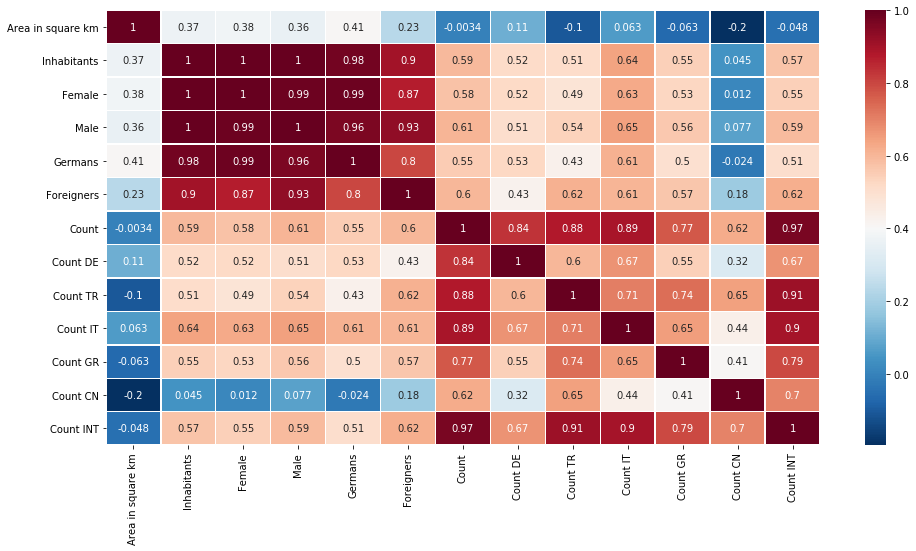

In [194]:
fig, ax = plt.subplots(figsize=(16,8)) 
sb.heatmap(census_venues_merge_corr, 
            xticklabels=census_venues_merge_corr.columns,
            yticklabels=census_venues_merge_corr.columns,
            cmap='RdBu_r',
            annot=True,
            linewidth=0.5)

In [197]:
census_venues_merge_corr.index

Index(['Area in square km', 'Inhabitants', 'Female', 'Male', 'Germans',
       'Foreigners', 'Count', 'Count DE', 'Count TR', 'Count IT', 'Count GR',
       'Count CN', 'Count INT'],
      dtype='object')

In [211]:
dif_df = census_venues_merge_corr.loc[["Germans", "Foreigners"], ["Count", "Count DE", "Count TR", "Count IT", "Count GR", "Count CN", "Count INT"]]
dif_series = (dif_df.loc["Germans"] - dif_df.loc["Foreigners"])
dif_series.name = "Difference"
dif_df.append(dif_series)

Count  Count DE  Count TR  Count IT  Count GR  Count CN  \
Germans     0.551441  0.525291  0.430631  0.614693  0.499301 -0.024193   
Foreigners  0.600077  0.425744  0.615729  0.606550  0.568396  0.183584   
Difference -0.048636  0.099547 -0.185098  0.008143 -0.069095 -0.207777   

            Count INT  
Germans      0.509210  
Foreigners   0.619981  
Difference  -0.110772

From that table we see that there is a slight difference between the correlation values. There is a trend that districts with a larger German population has more German venues. Furthermore, districts with a larger foreign population has more international (non DE) venues.

# Analysis of Venues

In [267]:
joined_venues = all_venues.set_index("ID").join(venue_details.set_index("ID"))

In [275]:
joined_venues.sort_values("Rating", ascending=True)

Name  \
ID                                                                            
4d4a848eb480a1439cb62fec                                         McDonald's   
4cf7e1330a71224b54d82593                                    Der Goldene Wok   
4f818d49e4b050ced6dbd595                                     Sense of Taste   
4bc8efd7762beee1a7b83d38                                Holiday Inn Express   
4b058851f964a5205ebe22e3                                Zum Schwarzen Stern   
4b5895e5f964a520ab5f28e3                                    Ding Ding Sheng   
4cdd7694c409b60cf595e01a                                         Italissimo   
4bf4c3dc2d6295213e2d6058                   InterCityHotel Frankfurt Airport   
4da48fc6b521224b3b5035ee                                       DoyDoy Döner   
5549fd22498e4f3ae5dd550a                                               Vito   
51372e7ae4b08fbb2aadaa6c                         China Restaurant New World   
509fe800e4b0a0263fab77e1                         Ristorante Il Quadrifoglio   
5b3225a7e65d0c002c94296b                              Frankfurter Wirtshaus   
4bdbf47463c5c9b62c122a68                                         Tower Cafe   
4bd72bbc637ba5939b73f970                                          Vita Vera   
5001c4fae4b034c293b276a0                                         Fantasia 5   
4da032e94977236afbc3bd96                                        La Terrazza   
4ceebadeb80da093040c2900                      Restaurant Unterschweinstiege   
555e1fed498e8bc2547cfffa                                            Ludwigs   
4b0ae398f964a5207f2923e3                                           Zapfhahn   
4ca9be2344a8224b7dff2340                             Niederräder Kebap-Haus   
4c1b7e3dc09ed13ac37c828e                                        Da Marietto   
4b066834f964a52096eb22e3                      Libertos Pizzeria Dick & Doof   
4b93ee8ff964a520bb5a34e3                                          Shangrila   
4b7984c1f964a52062fe2ee3                                             Lilium   
4b7984c1f964a52062fe2ee3                                             Lilium   
4bd88ac911dcc92875c9f633                                           Dionysos   
4cb60d32b315a09362199976                                      Struwwelpeter   
4cea6a4ee1eeb60c0808aeae                                     China-Paradies   
4eb2ddaddab472d4de9d6a41                                          Jing Jing   
4feca99be4b042799e44e8ef                                         Immer satt   
4baf8c5bf964a5207b093ce3                               QGREENHOTEL by Meliá   
4c01595358dbc928a22dee6b                                  Nibelungenschänke   
53385570498ed4b32806d5e3                                            Bagutta   
4debe04952b11677f06109ad                                 Restaurant Taverne   
4c2c7ad4ae6820a1f9581943                                           Luftikus   
4ba133b8f964a5209da137e3                                          Rusticale   
4ba133b8f964a5209da137e3                                          Rusticale   
56e73b86498e2d7146a4c199                                             Aposto   
4b729aa6f964a5203c802de3                            Restaurant Römer-Bembel   
5253f1e5498e6b4a6ca787d8                                Alica Premium Doner   
4c36fcc6298e9c74eddf07e3                Ristorante & Pizzeria Il Gondoliere   
4db1d7c06a231f2e4a734fdb                                         Bella Roma   
4cf6b4b8d3a8a1cd0dc9d243                                       Maximilian's   
4c1371bd583c9c74eb6d3fa4                                        Drosselbart   
4f907123e4b0c550e208014f  Livingstonscher Pferdestall Restaurant "Herr F...   
4b105692f964a520316e23e3                                    Neuer Volkswirt   
4c586fa76418a593a2ab810e                                      La Dolce Vita   
4b05884ff964a520afbd22e3                                    Steinernes Haus   
4cab661a97c8a1cdadfd9aa5                  

In [276]:
top10 = joined_venues.sort_values("Rating", ascending=False).head(10)
bottom10 = joined_venues.sort_values("Rating", ascending=True).head(10)

In [280]:
top10

Name  \
ID                                                         
566d741d498e798119fcd349  The Holy Cross Brewing Society   
568c338d498e0b9ee997a939         Bunca Barista & Caterer   
4fad5eede4b06644b6b20362                           oheim   
4c069f398a81c9b6ff012690           Trattoria i Siciliani   
4e11a3be1f6e671dd9e93729              Jumeirah Frankfurt   
4b058850f964a52038be22e3                          Omonia   
4b2a1c27f964a52048a524e3                       da Cimino   
5496f23b498e787a0e9b3be2                      Sugar Mama   
4d977e6c0caaa143736294b3      Parthenon Greek Restaurant   
4b6aae9df964a520f5db2be3          Manufactum brot&butter   

                                            Address        Lat       Lng  \
ID                                                                         
566d741d498e798119fcd349                Fahrgasse 7  50.110165  8.687225   
568c338d498e0b9ee997a939             Kirchnerstr. 4  50.111132  8.675198   
4fad5eede4b06644b6b20362    Oppenheimer Landstr. 48  50.100322  8.680100   
4c069f398a81c9b6ff012690        Walter-Kolb-Str. 17  50.104896  8.684428   
4e11a3be1f6e671dd9e93729    Thurn-und-Taxis-Platz 2  50.114999  8.680512   
4b058850f964a52038be22e3   Eckenheimer Landstr. 126  50.127359  8.685447   
4b2a1c27f964a52048a524e3            Adalbertstr. 29  50.119496  8.645682   
5496f23b498e787a0e9b3be2     Kurt-Schumacher-Str. 2  50.109800  8.688115   
4d977e6c0caaa143736294b3            Stresemannallee  50.101037  8.674486   
4b6aae9df964a520f5db2be3  Bockenheimer Anlage 49-50  50.115958  8.670772   

                         Cuisine            District  Likes  Listed  Photos  \
ID                                                                            
566d741d498e798119fcd349      DE            Altstadt    220     620     163   
568c338d498e0b9ee997a939      IT          Innenstadt     69     180      60   
4fad5eede4b06644b6b20362      IT  Sachsenhausen-Nord     86     364      70   
4c069f398a81c9b6ff012690      IT  Sachsenhausen-Nord    168     179      72   
4e11a3be1f6e671dd9e93729      DE          Innenstadt    272      53     441   
4b058850f964a52038be22e3      GR        Nordend-West     40      92      16   
4b2a1c27f964a52048a524e3      IT          Bockenheim    285     442     115   
5496f23b498e787a0e9b3be2      DE          Innenstadt     86     218      46   
4d977e6c0caaa143736294b3      GR  Sachsenhausen-Nord     68      39      67   
4b6aae9df964a520f5db2be3      DE         Westend-Süd     94     160      46   

                          Price  Rating  Rating Signals  Tips  
ID                                                             
566d741d498e798119fcd349    1.0     9.2           291.0    70  
568c338d498e0b9ee997a939    1.0     9.1           102.0    25  
4fad5eede4b06644b6b20362    1.0     9.1           124.0    37  
4c069f398a81c9b6ff012690    NaN     9.0           296.0   149  
4e11a3be1f6e671dd9e93729    NaN     8.9           360.0    76  
4b058850f964a52038be22e3    2.0     8.9            62.0    24  
4b2a1c27f964a52048a524e3    2.0     8.9           410.0   113  
5496f23b498e787a0e9b3be2    1.0     8.8           118.0    29  
4d977e6c0caaa143736294b3    2.0     8.8           100.0    28  
4b6aae9df964a520f5db2be3    NaN     8.7           120.0    19

In [281]:
bottom10

Name  \
ID                                                           
4d4a848eb480a1439cb62fec                        McDonald's   
4cf7e1330a71224b54d82593                   Der Goldene Wok   
4f818d49e4b050ced6dbd595                    Sense of Taste   
4bc8efd7762beee1a7b83d38               Holiday Inn Express   
4b058851f964a5205ebe22e3               Zum Schwarzen Stern   
4b5895e5f964a520ab5f28e3                   Ding Ding Sheng   
4cdd7694c409b60cf595e01a                        Italissimo   
4bf4c3dc2d6295213e2d6058  InterCityHotel Frankfurt Airport   
4da48fc6b521224b3b5035ee                      DoyDoy Döner   
5549fd22498e4f3ae5dd550a                              Vito   

                                                           Address        Lat  \
ID                                                                              
4d4a848eb480a1439cb62fec                                Terminal 1  50.047871   
4cf7e1330a71224b54d82593                    Mainzer Landstraße 793  50.099010   
4f818d49e4b050ced6dbd595                   Terminal 2, Concourse D  50.051927   
4bc8efd7762beee1a7b83d38                        Gutleutstrasse 296  50.097532   
4b058851f964a5205ebe22e3                               Römerberg 6  50.110274   
4b5895e5f964a520ab5f28e3                              Moselstr. 23  50.107416   
4cdd7694c409b60cf595e01a                      Terminal 1, Gate A22  50.046548   
4bf4c3dc2d6295213e2d6058  Am Luftbrückendenkmal 1 / Cargo City Süd  50.032976   
4da48fc6b521224b3b5035ee                                       NaN  50.114995   
5549fd22498e4f3ae5dd550a                         Frankfurt Airport  50.051985   

                               Lng Cuisine         District  Likes  Listed  \
ID                                                                           
4d4a848eb480a1439cb62fec  8.573398      DE        Flughafen     51       7   
4cf7e1330a71224b54d82593  8.562728      CN             Nied      6       4   
4f818d49e4b050ced6dbd595  8.585748      DE        Flughafen      5       1   
4bc8efd7762beee1a7b83d38  8.646259      DE   Gutleutviertel     26       3   
4b058851f964a5205ebe22e3  8.682466      DE         Altstadt     21       5   
4b5895e5f964a520ab5f28e3  8.667175      CN  Bahnhofsviertel     12      12   
4cdd7694c409b60cf595e01a  8.567226      IT        Flughafen     18       4   
4bf4c3dc2d6295213e2d6058  8.592203      DE        Flughafen     63       2   
4da48fc6b521224b3b5035ee  8.690183      TR       Innenstadt     12       1   
5549fd22498e4f3ae5dd550a  8.587016      IT        Flughafen      8       1   

                          Photos  Price  Rating  Rating Signals  Tips  
ID                                                                     
4d4a848eb480a1439cb62fec      65    1.0     4.6           197.0    53  
4cf7e1330a71224b54d82593      17    2.0     5.2            22.0     7  
4f818d49e4b050ced6dbd595      16    1.0     5.2            13.0     3  
4bc8efd7762beee1a7b83d38      17    NaN     5.2            75.0    25  
4b058851f964a5205ebe22e3      75    2.0     5.2            50.0    14  
4b5895e5f964a520ab5f28e3      24    2.0     5.3            31.0    11  
4cdd7694c409b60cf595e01a      43    2.0     5.3            43.0    11  
4bf4c3dc2d6295213e2d6058      77    NaN     5.3           152.0    42  
4da48fc6b521224b3b5035ee      12    NaN     5.3            30.0     7  
5549fd22498e4f3ae5dd550a      27    2.0     5.4            22.0     3

In [279]:
latitude = 50.11552
longitude = 8.68417
frankfurt_geo = geodata_path # geojson file

m = folium.Map(
    location=[latitude, longitude],
    zoom_start=11  # Limited levels of zoom for free Mapbox tiles.
)

def style_function(feature):
    if feature["properties"]["name"] :
        style = {
            'fillColor': "blue",

            }
    else:
        style = {
            "fillColor": "white"
            }
        
    return style

folium.GeoJson(
    geodata_path,
    name='geojson'
).add_to(m)

colors = {"DE": "red",
          "TR": "blue",
          "IT": "green",
          "GR": "purple",
          "CN": "orange"}
    
for index, row in top10.iterrows():

    lat = row["Lat"]
    lng = row["Lng"]
    label = row["Name"]
    color = "blue"

    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
                [lat, lng],
                radius=5,
                popup=label,
                color=color,
                fill=True,
                fill_color='#3186cc',
                fill_opacity=0.7,
                parse_html=False).add_to(m)
    
for index, row in bottom10.iterrows():

    lat = row["Lat"]
    lng = row["Lng"]
    label = row["Name"]
    color = "red"

    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
                [lat, lng],
                radius=5,
                popup=label,
                color=color,
                fill=True,
                fill_color='#3186cc',
                fill_opacity=0.7,
                parse_html=False).add_to(m)   

m

In [291]:
average_venue_stats = joined_venues.drop(["Lat", "Lng"], axis=1).groupby("District").mean()
average_venue_stats

Likes     Listed     Photos     Price    Rating  \
District                                                                  
Altstadt            52.775000  64.500000  63.300000  1.864865  7.058065   
Bahnhofsviertel     72.800000  54.971429  59.828571  1.645161  7.193939   
Bergen-Enkheim       2.545455   0.454545   5.727273  2.000000  6.400000   
Berkersheim          7.000000   1.000000   8.000000  2.000000  6.500000   
Bockenheim          17.021277  14.872340  13.489362  1.690476  6.993103   
Bonames              3.000000   0.600000   2.000000  1.750000  6.800000   
Bornheim            20.708333  15.666667  14.041667  1.736842  7.088235   
Dornbusch            5.000000   0.400000   1.800000  1.750000  6.433333   
Eckenheim            2.000000   1.500000  10.250000  1.750000  6.400000   
Eschersheim          8.500000   4.250000   5.250000  2.000000  6.650000   
Fechenheim          18.333333  11.333333  18.666667  1.666667  7.050000   
Flughafen           33.931034   3.137931  62.482759  1.857143  6.166667   
Frankfurter Berg     5.500000   2.000000   5.000000  1.000000  7.900000   
Gallus              19.062500  10.645833  15.833333  1.833333  6.874074   
Ginnheim            16.285714   5.000000   8.000000  1.800000  7.325000   
Griesheim            2.666667   0.666667   1.000000  1.000000  7.000000   
Gutleutviertel      35.846154  20.846154  36.000000  1.900000  6.857143   
Harheim              3.000000   0.000000   1.666667  2.000000  6.300000   
Hausen               2.500000   1.500000   1.500000  2.000000       NaN   
Heddernheim          6.090909   1.454545   3.454545  1.875000  6.975000   
Höchst              15.444444   5.666667  19.444444  1.666667  7.383333   
Innenstadt          51.950000  36.033333  58.483333  1.812500  7.516981   
Kalbach-Riedberg     2.750000   0.875000   2.750000  1.666667  6.700000   
Nied                 2.250000   1.250000   5.250000  2.000000  5.200000   
Nieder-Erlenbach    11.500000   2.500000  14.500000  2.000000  7.300000   
Nieder-Eschbach      2.666667   0.333333   1.333333  2.000000  6.200000   
Niederrad           10.375000   3.750000  14.000000  2.000000  6.833333   
Niederursel         19.000000   3.500000   4.000000  1.750000  7.166667   
Nordend-Ost         23.650000  20.500000  13.150000  1.833333  7.569231   
Nordend-West        19.826087  23.956522  16.956522  1.894737  7.411765   
Oberrad             19.500000   8.833333  30.500000  2.000000  7.433333   
Ostend              44.681818  28.181818  37.909091  1.888889  7.313333   
Praunheim           10.250000   2.750000   3.000000  2.000000  6.600000   
Preungesheim         6.000000   0.666667   4.666667  2.000000  6.650000   
Riederwald           7.000000   1.000000   1.333333  2.000000  7.300000   
Rödelheim            5.444444   1.333333   4.666667  1.857143  6.580000   
Sachsenhausen-Nord  43.934426  45.426230  49.344262  1.840000  7.503922   
Sachsenhausen-Süd   16.500000   9.687500  13.437500  1.833333  7.176923   
Schwanheim          14.666667  16.166667   9.500000  2.000000  7.250000   
Seckbach            19.333333  11.500000  15.666667  1.600000  7.600000   
Sindlingen           2.000000   0.000000   1.000000  2.000000       NaN   
Sossenheim          13.500000   2.000000   8.500000  2.000000  8.000000   
Unterliederbach      2.500000   0.500000   0.500000  2.000000       NaN   
Westend-Nord        46.166667  47.000000  17.666667  1.500000  7.700000   
Westend-Süd         26.230769  14.794872  21.358974  1.909091  7.274286   
Zeilsheim            7.000000   0.000000   4.000000  2.000000  7.300000   

                    Rating Signals       Tips  
District                                       
Altstadt                106.161290  21.750000  
Bahnhofsviertel         117.848485  27.257143  
Bergen-Enkheim           13.000000   0.636364  
Berkersheim              14.000000   4.000000  
Bockenheim               42.413793   7.659574  
Bonames                  11.000000   1.200000  
Bornheim                 42.647059   7.

In [294]:
latitude = 50.11552
longitude = 8.68417

m = folium.Map(
    location=[latitude, longitude],
    zoom_start=11  # Limited levels of zoom for free Mapbox tiles.
)

folium.Choropleth(
    geo_data=geodata_path,
    name='choropleth',
    data=average_venue_stats.reset_index(),
    columns=['District', 'Rating'],
    key_on='feature.properties.name',
    fill_color='YlOrRd',
    fill_opacity=0.8,
    line_opacity=1,
    legend_name='AverageRatings'
).add_to(m)


m

In [295]:
pearsoncorr_venues = average_venue_stats.corr(method='pearson')

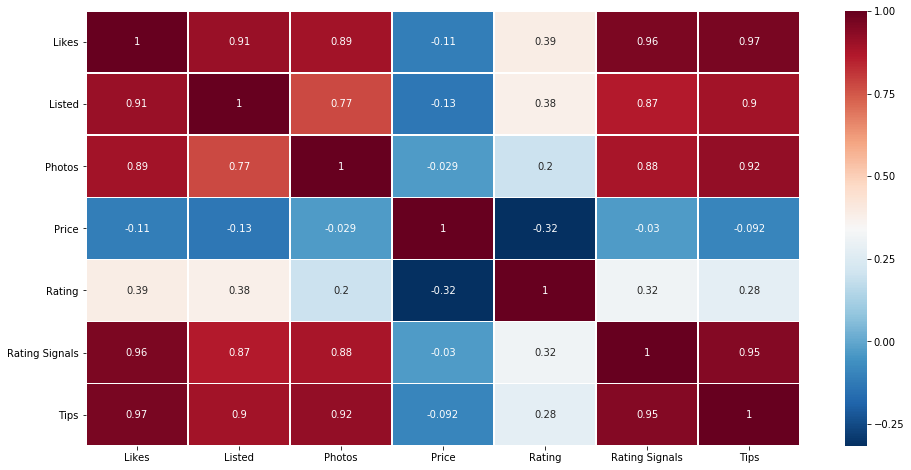

In [296]:
fig, ax = plt.subplots(figsize=(16,8))         # Sample figsize in inches
sb.heatmap(pearsoncorr_venues, 
            xticklabels=pearsoncorr_venues.columns,
            yticklabels=pearsoncorr_venues.columns,
            cmap='RdBu_r',
            annot=True,
            linewidth=0.5)
